ok, first i will work off of recordings in order to

1) get scoring working

2) make a simple classifier for state-space

In [4]:
import os, subprocess

extract frames from video

In [22]:
video_path = '../resources/taikotemp/recordings/test_0.avi'
extract_path = '../resources/taikotemp/recordings/extracted'
file_info = ''

if not os.path.exists(extract_path):
    os.mkdir(extract_path)

fps_cmd = 'ffmpeg -hide_banner -i {}'.format(video_path)

try:
    subprocess.check_output(fps_cmd, stderr=subprocess.STDOUT, shell=True)
except subprocess.CalledProcessError as e:
    file_info = e.output
file_info = file_info.decode('utf-8')
file_info = file_info.split('\n')

fps = None

for line in file_info:
    if 'fps' in line:
        split_line = line.split(" ")
        fps = split_line[split_line.index('fps,')-1]

if fps is not None:
    extract_command = "ffmpeg -i {} -r {} {}/out-%d.png".format(video_path, fps, extract_path)
    subprocess.call(extract_command, shell=True)


In [24]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from PIL import Image

In [63]:
mask_path = '../resources/taikotemp/what_i_want/'

def clean_pic(fname):
    starting_pic = Image.open(fname, 'r')
    as_array = np.asarray(starting_pic)
    as_array = as_array[:,:,:3]
    return as_array

def clean_array_mask(idx):
    start_pic = clean_pic(mask_path + '{}.png'.format(idx))
    
    mask = start_pic == [0, 255, 0]
    to_return = start_pic.copy()
    to_return[mask] = -1
    
    return to_return

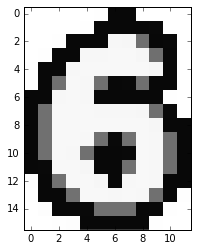

In [82]:
plt.imshow(clean_array_mask(6), interpolation ='none')
plt.show()

In [74]:
masks = [clean_array_mask(i) for i in range(10)]

In [84]:
test_frame = clean_pic(extract_path + '/out-6549.png')

In [72]:
def show_screen(scrot_as_array):
    plt.figure(figsize=(5,10))
    plt.axis('off')
    plt.imshow(scrot_as_array, interpolation ='none')
    plt.show()

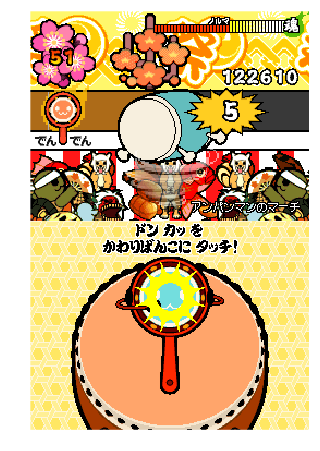

In [85]:
show_screen(test_frame)

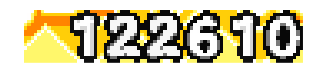

In [88]:
score_crop = test_frame[52:68,-94:-10,:]
show_screen(score_crop)

In [259]:
last_score = 0
num_detect_thresh = 80

def update_score(current_frame):
    score_crop = current_frame[52:68,-94:-10,:]
    read_num = []
    # temp = [] # for figuring out thresholds
    for i in reversed(range(7)):
        looking_at = score_crop[:, 12 * i:12 * (i + 1), :]
        #  mse = [np.sum((looking_at - masks[j]) ** 2) / 576 for j in range(10)]
        # trying an abs_diff instead
        abs_diff = [np.mean(np.fabs(looking_at - masks[j])) for j in range(10)]
        most_likely = np.argmin(abs_diff)
        # print(most_likely, mse[most_likely])
        if abs_diff[most_likely] > num_detect_thresh:
            break
        read_num += [most_likely]
        # temp += [mse[most_likely]]
        # temp += [abs_diff[most_likely]]
    new_score = sum([n * 10 ** i for i, n in enumerate(read_num)])
    # score can't go down, and differs by at least 100 and at most 25k?
    # (stupid things where you have to mash and u get bonus for complete)
    score_diff = new_score - last_score
    if score_diff < 100 or score_diff > 25000:
        new_score = last_score
    return (new_score, score_diff, new_score == last_score)

In [260]:
last_score = 0
test_all = []
for e_id in range(1, 7036, 1):
    t_frame = clean_pic(extract_path + '/out-{}.png'.format(e_id))
    scores = update_score(t_frame)
    last_score = scores[0]
    test_all += [scores]   

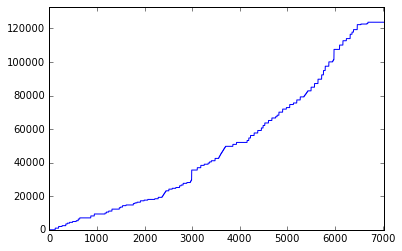

In [261]:
plt.plot([t[0] for t in test_all])
plt.axis([0,7036,-1,133000])
plt.show()

now for state-space. your score gets bumped the frame after a hit